In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from data.dataset import COWCDataset
from model.loss import RegClsLoss
from model.model import VGGRegCls
from utils.train import train_model
import glob
import torch
import torchvision

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [3]:
file_list = []
path_train = '/home/kruglov/projects/siod/datasets/cowc/{}/train/*'
path_test = '/home/kruglov/projects/siod/datasets/cowc/{}/test/*'

In [4]:
for ds in ['Selwyn_LINZ','Columbus_AFRL','Potsdam_ISPRS']:
    file_list = file_list + glob.glob(path_train.format(ds)) + glob.glob(path_test.format(ds))
print('Datasets have {} images in total.'.format(len(file_list)))

Datasets have 42683 images in total.


In [5]:
batch_size = 4

In [6]:
dataset = COWCDataset(file_list, transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, shuffle= True)

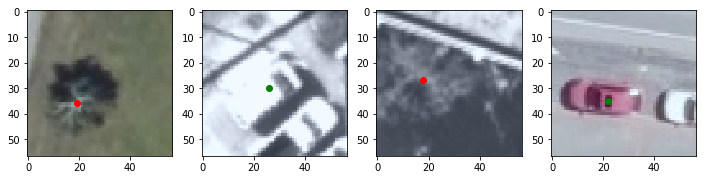

In [7]:
# Sample images from datasets
# positive examples labeled with green marks

inputs, labels = iter(dataloader).next()
coords = labels.data.numpy() * 10 + 28
plt.figure(figsize= (12,3))
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    mark = 'go' if labels[i][2] == 1 else 'ro'
    plt.imshow(np.clip(np.transpose(inputs[i], (1,2,0)) * 0.22 + 0.45, 0, 1))
    plt.plot(coords[i][0], coords[i][1], mark);

In [8]:
model = VGGRegCls().cuda()
criterion = RegClsLoss()
optimizer = torch.optim.SGD(params= model.parameters(), lr= 0.0001, weight_decay= 0.9)

In [9]:
train_model(model, dataloader, criterion, optimizer, train_iterations= 100)

  1%|          | 1/100 [00:00<00:10,  9.28it/s]

Epoch 0, loss 0.8973718988895416


  1%|          | 1/100 [00:00<00:11,  8.84it/s]

Epoch 1, loss 0.8705150020122528


  1%|          | 1/100 [00:00<00:11,  8.85it/s]

Epoch 2, loss 0.8098920539021492


  1%|          | 1/100 [00:00<00:10,  9.85it/s]

Epoch 3, loss 0.8253532439470291


  1%|          | 1/100 [00:00<00:12,  8.15it/s]

Epoch 4, loss 0.8071744602918625


  1%|          | 1/100 [00:00<00:11,  8.82it/s]

Epoch 5, loss 0.7644273462891579


  1%|          | 1/100 [00:00<00:12,  7.80it/s]

Epoch 6, loss 0.7561197713017463


  1%|          | 1/100 [00:00<00:10,  9.40it/s]

Epoch 7, loss 0.7428533908724785


  1%|          | 1/100 [00:00<00:19,  5.14it/s]

Epoch 8, loss 0.7669539743661881


100%|██████████| 100/100 [00:11<00:00,  9.35it/s]

Epoch 9, loss 0.7109810319542885
Training finished!


In [11]:
model.train(False);

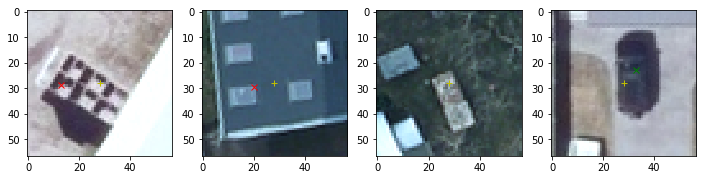

In [39]:
inputs, labels = iter(dataloader).next()
outputs_l, outputs_c = model(torch.autograd.Variable(inputs).cuda())

pred_coords = outputs_l.cpu().data.numpy() * 10 + 28
gt_coords = labels.data.numpy() * 10 + 28

plt.figure(figsize= (12,3))
for i in range(batch_size):
    plt.subplot(1, batch_size, i+1)
    if float(labels[i,2]) > 0:
        plt.plot(gt_coords[i][0], gt_coords[i][1], 'gx')
    if float(outputs_c[i][1].cpu().data) > 0.5:
        plt.plot(pred_coords[i][0], pred_coords[i][1], 'rx')
    plt.plot(28,28,'y+')
    plt.imshow(np.clip(np.transpose(inputs[i], (1,2,0)) * 0.25 + 0.46, 0, 1));